In [1]:
import gym
import math
import random
import keras
import os
import tensorflow as tf
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output
from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.transform import rescale
from keras.models import Sequential, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Setting Global Parameters

class DQN_Agent(): 
    
    def __init__(self, num_state, num_action, params):
        
        self.params =  params
        self.num_state = num_state
        self.num_action = num_action
        self.steps = 0        
        self.gamma = params['gamma']   
        self.eps_min = params['eps_min']
        self.eps_max = params['eps_max']
        self.eps = params['eps_max']
        self.decay = params['decay']
        self.learning_rate = params['lr']
        self.batch_size = params['batch_size']
        self.capacity = params['capacity']
        self.load_model = params['load_model']
        self.freq_target = params['freq_target']
        self.model = self._create_model(load = self.load_model)
        self.target_model= self._create_model(load = self.load_model)
        self.memory=[]
        
    # Model OK    
    def _create_model(self, load = False):
        
        def huber_loss(y_true, y_pred, in_keras=True):
            err = y_true - y_pred
            delta = 2.0
            quadratic_term = 0.5 * err**2
            linear_term = delta*(abs(err) - 0.5*delta)
            use_linear_term = (abs(err) > 1.0)
            
            if in_keras:
                use_linear_term = K.cast(use_linear_term, 'float32')
            return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term
            
        if not load:
            model =  Sequential()

            model.add(Conv2D(input_shape = self.num_state, filters = 32, 
                             kernel_size = 8, strides=2, 
                             activation = 'elu'))

            model.add(Conv2D(filters = 64, kernel_size = 4, strides=2, 
                             activation = 'elu'))

            model.add(Conv2D(filters = 64, kernel_size = 2, strides=1,
                             activation = 'elu'))

            model.add(Flatten()) 
            model.add(Dense(units=512, kernel_initializer='glorot_normal',
                            activation = 'relu')) 
            model.add(Dense(self.num_action))              

            optimizer = Adam(lr = self.learning_rate)
            model.compile(optimizer = optimizer, loss = huber_loss)

            print("Model constructed...", end ="\r", flush=True)
        else: 
            model = load_model('dqn-atari.h5', custom_objects={'huber_loss' : huber_loss})
            print("Model loaded...", end ="\r", flush=True)
        
        return model   
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    # Check OK
    def predict(self, state):        
        if len(state.shape) == 3:
            state = np.expand_dims(state, axis=0)
        return self.model.predict(state)
    
    def predict_target(self, state):        
        if len(state.shape) == 3:
            state = np.expand_dims(state, axis=0)
        return self.model.predict(state)
    
    # Check OK
    def observe(self, state, action, next_state, reward, done):
        self.memory.append((state, action, next_state, reward, done))    
        
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
    
        self.eps = self.eps_min + (self.eps_max - self.eps_min) * math.exp(-self.steps * self.decay)        
        self.steps +=1 
        
        if self.steps % self.freq_target ==0:
            self.update_target_model()
        
    # Check OK    
    def act(self, state):      
        if np.random.rand() < self.eps:
            return np.random.choice(self.num_action)
        else:            
            return np.argmax(self.predict(state))                 
    
    def replay(self):                
        batch_len = min(self.batch_size, len(self.memory))        
        batch = np.array(random.sample(self.memory, batch_len))        
        
        state = np.array([episode[0] for episode in batch])
        action =  np.array([episode[1] for episode in batch])
        next_state = np.array([episode[2] for episode in batch])
        reward =  np.array([episode[3] for episode in batch])
        done = np.array([episode[4] for episode in batch])
        
        q = np.array(self.predict(state))
        q_ = np.array(self.predict_target(next_state))
        
        for i in range(batch_len):
            q[i][action[i]] = reward[i]+ self.gamma*np.max(q_[i])* (1-done[i]) 
            
        history = self.model.fit(state, q, 
                   verbose = 0, epochs=1, shuffle = False, batch_size = 32) 
        return history, np.mean(q, axis = 0)


class input_pipeline():    
    
    def __init__(self, state):       
        self.history_length = 4        
        self.input_x=[]
        self.input_x = [self._preprocess(state) for i in range(self.history_length)]
        self.x = np.moveaxis(np.array(self.input_x), 0, -1) 

    def _preprocess(self, state):    
        
        state = np.mean(state, axis = 2).astype(np.uint8)
        state = state[::2, ::2]
        state = state[15:97,3:77]
        state[state==162] = 80
        state[state==180] = 90
        state[state==198] = 100
        state[state==200] = 110   
        return state / 255
    
    def update(self, state):
        self.input_x.pop(0)
        self.input_x.append(self._preprocess(state))
        self.x = np.moveaxis(np.array(self.input_x), 0, -1)
    


In [3]:
def main(train=True):
    
    env = gym.make('BreakoutDeterministic-v4')
    #env = gym.wrappers.Monitor(env, './tmp/breakout-1', force=True)
    num_state = env.observation_space.shape    
    num_action = env.action_space.n
    
    agent = DQN_Agent((82,74,4), num_action, params) 
    loss, mean_av, render, iteration = [], [], False, 0    
    
    for episode in range(N_EPISODE):        
        state, step, total_reward, done, render = env.reset(), 0, 0, False, False        
        pipeline = input_pipeline(state)
       
        if episode > 0:
            render = True
        
        while not done:
            if render:
                env.render()
                
            state = pipeline.x
            action = agent.act(state)            
            next_state, reward, done, _ = env.step(action)  
            
            pipeline.update(next_state)
            next_state = pipeline.x             
            total_reward += reward
            step +=1
            
            if train and step >= 4 :    
                agent.observe(state, action, next_state, np.sign(reward), done)            
                history, mean_action_value = agent.replay()
                loss.append(history.history['loss'])
                mean_av.append(np.mean(mean_action_value))                
        
        if episode % 10==0:
            agent.model.save('dqn-atari.h5')
        iteration+=step
        
        print('Episode: {}/{}, Step: {}, Iteration: {}, Reward: {}'
              .format(episode+1, N_EPISODE, step, iteration, total_reward), 
              end = '\r', flush = True) 
        
    return np.array(loss), np.array(mean_av)           

In [4]:
params = {}
params['gamma'] = 0.99
params['eps_min'] = 0.10
params['eps_max'] = 1.00
params['decay'] = 5e-5
params['batch_size'] = 64
params['lr'] = 5e-4
params['capacity'] = 10000
params['freq_target'] = 2
params['load_model'] = False

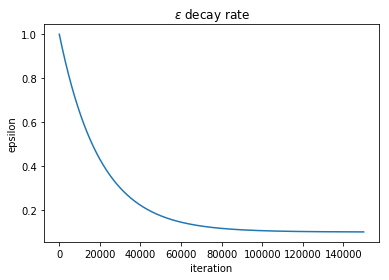

In [5]:
x = np.array(range(150000))
y = params['eps_min'] + (params['eps_max']-params['eps_min'])*np.exp(-params['decay']*x)
plt.plot(y)
plt.title('$\epsilon$ decay rate')
plt.ylabel('epsilon')
plt.xlabel('iteration')
plt.show()

In [6]:
N_EPISODE = 1
loss, mean_q = main(True)

[2017-11-22 23:42:19,268] Making new env: BreakoutDeterministic-v4


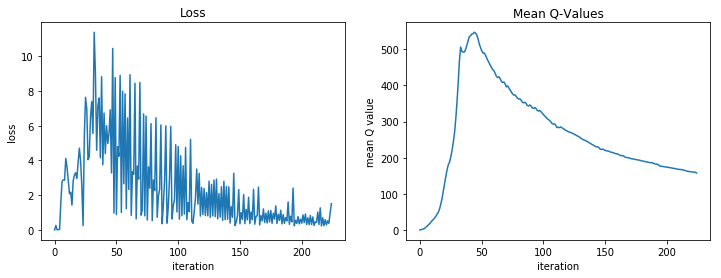

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(loss)

plt.subplot(1,2,2)
plt.plot(mean_q)
plt.title('Mean Q-Values')
plt.xlabel('iteration')
plt.ylabel('mean Q value')
plt.show()